# Plot posterior estimates 

This notebook is for plotting parameter values and tree metrics taken from the posterior rather than the summary tree

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [4]:
def read_in_migration_rates_mtt(log_file_path):
    
    mig_rates_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        for line in infile:
            
            # use the first line to find the migration rate columns
            if "posterior" in line:
                all_cols = line.split("\t")
                migration_column_indices = []   # list to store column indices
                mig_rates_key = {}   # dictionary to store the column index to map to column name
                
                for i in range(len(all_cols)):
                    col = all_cols[i]
                    if ".rateMatrix_" in col:
                        migration_column_indices.append(i)

                # make an empty dictionary to store migration rates and generate dictionary to convert index to name
                for m in migration_column_indices:
                    name = line.split("\t")[m]
                    mig_rates_key[m] = name
                    mig_rates_dict[name] = []
                
            # read in actual parameter estimates and store in dictionary
            else:
                sample = line.split("\t")[0]
                mig_rates_dict["sample"].append(sample)
                
                for index in migration_column_indices:
                    name = mig_rates_key[index]
                    mig_rates_dict[name].append(line.split("\t")[index])
                    
                
    return(mig_rates_dict)

In [5]:
def read_in_migration_rates_mascot(log_file_path):
    
    mig_rates_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
                
                if "sample" in line.lower():
                    all_cols = line.split("\t")
                    migration_column_indices = []   # list to store column indices
                    mig_rates_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "_migration" in col:
                            migration_column_indices.append(i)

                    # make an empty dictionary to store migration rates and generate dictionary to convert index to name
                    for m in migration_column_indices:
                        name = line.split("\t")[m]
                        mig_rates_key[m] = name
                        mig_rates_dict[name] = []
                    
                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    mig_rates_dict["sample"].append(sample)

                    for index in migration_column_indices:
                        name = mig_rates_key[index]
                        mig_rates_dict[name].append(line.split("\t")[index])
                    
                
    return(mig_rates_dict)

In [6]:
# log file paths
constant_human_on = {"label": "constant-human-on","mig_direction":"backwards in time",
    "log":"beast-runs/2021-03-15-mascot-3deme-constant/with-human-mig/3deme-mascot-constant-with-human-mig-2021-03-15.combined.log"}
constant_human_off = {"label": "constant-human-off","mig_direction":"backwards in time",
    "log":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/3deme-mascot-constant-no-human-mig-2021-03-15.combined.log"}
skyline_human_on =  {"label": "skyline-human-on", "mig_direction":"forwards in time",
                     "log": "beast-runs/2021-03-15-mascot-3deme-skyline-with-mig-history/with-human-mig/2021-04-27-mascot-3deme-skyline-with-human-mig.combined.log"}
skyline_human_off = {"label": "skyline-human-off", "mig_direction":"forwards in time",
                     "log": "beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/with-extra-logger/combined-logfile-2021-08-23.log"}

In [7]:
to_run = skyline_human_off

log_file_path = to_run['log']
label = to_run['label']
mig_direction = to_run['mig_direction']

burnin_percent = 0.0

migration_rates = read_in_migration_rates_mascot(log_file_path)

In [8]:
mig_df = pd.DataFrame.from_dict(migration_rates)
print(len(mig_df))

rows_to_remove = int(len(mig_df)* burnin_percent)
mig_df = mig_df.iloc[rows_to_remove:]

print(len(mig_df))
mig_df.head()

3641
3641


,sample,f_migration.domestic_to_human,f_migration.domestic_to_wild,f_migration.human_to_domestic,f_migration.human_to_wild,f_migration.wild_to_domestic,f_migration.wild_to_human
0,0,0.42208967844566586,0.05348156319556324,0.0,0.0,1.1548302581388146,0.021058989805980786
1,50000,0.32495498844126713,0.015152528246284788,0.0,0.0,1.1565399510393537,0.03479657137311102
2,100000,0.40753735039202726,0.017112732779781772,0.0,0.0,1.5277288762858787,0.0960976536629401
3,150000,0.47665469844720476,0.00880386617497896,0.0,0.0,0.978299303675461,0.03697025228082568
4,200000,0.5943604132210306,0.029162273460948684,0.0,0.0,0.8619760245853616,0.09151532082824006


In [9]:
mig_df_melted = mig_df.melt(id_vars = ['sample'])
mig_df_melted['variable'] = mig_df_melted['variable'].str.replace("f_migration.","").str.replace("b_migration.","")
#mig_df_melted['variable'] = mig_df_melted['variable'].str.replace("migModel.t:mtt-3-deme-4-rates-hot-chain-2020-11-05-it1.rateMatrix_","")
#mig_df_melted['variable'] = mig_df_melted['variable'].str.replace("_","_to_")

mig_df_melted.head()

,sample,variable,value
0,0,domestic_to_human,0.42208967844566586
1,50000,domestic_to_human,0.32495498844126713
2,100000,domestic_to_human,0.40753735039202726
3,150000,domestic_to_human,0.47665469844720476
4,200000,domestic_to_human,0.5943604132210306


In [10]:
# define colors 
domestic_to_human="#4E83AE"
domestic_to_wild="#90B2C4"

wild_to_domestic="#CEB540"
wild_to_human="#E0D188"

human_to_domestic="#DE4428"
human_to_wild="#EA8A79"

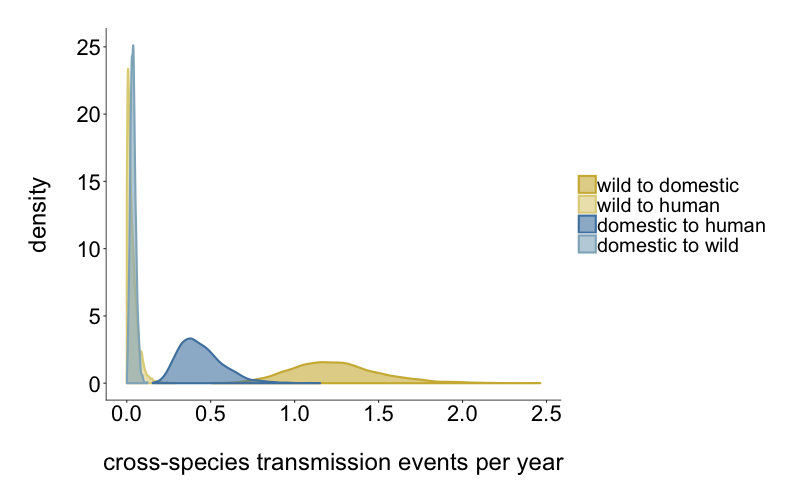

In [15]:
%%R -w 800 -h 500 -u px -i current_date,label,mig_direction,mig_df_melted,domestic_to_human,domestic_to_wild,wild_to_domestic,wild_to_human,human_to_wild,human_to_domestic # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("migration-rates-",label,"-",current_date,".pdf", sep="")
#output_filename = paste("migration-rates-mtt-3deme-4rates-2020-11-05.pdf", sep="")

mig_df_melted$value = as.numeric(mig_df_melted$value)

# remove some extra estimates that I don't need to show for virus club 
mig_df_melted <- mig_df_melted[!(mig_df_melted$variable=="human_to_wild"),]
mig_df_melted <- mig_df_melted[!(mig_df_melted$variable=="human_to_domestic"),]
#mig_df_melted <- mig_df_melted[!(mig_df_melted$variable=="wild_to_human"),]

# make factor for plotting order 
mig_df_melted$variable_f = factor(mig_df_melted$variable, levels=c("wild_to_domestic","wild_to_human","domestic_to_human","domestic_to_wild"))

p <- ggplot(data=mig_df_melted, aes(x=value, group=variable_f, color=variable, fill=variable)) + 
    geom_density(data=mig_df_melted, aes(x=value, group=variable_f, color=variable_f, fill=variable_f), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ncross-species transmission events per year",y="density\n")+
    #labs(x=paste("\nmigrations per lineage per year\n(",mig_direction,")",sep=""),y="density\n")+
     scale_color_manual(values=c(domestic_to_human=domestic_to_human,domestic_to_wild=domestic_to_wild,wild_to_domestic=wild_to_domestic,wild_to_human=wild_to_human,human_to_domestic=human_to_domestic,human_to_wild=human_to_wild), labels=c(domestic_to_human="domestic to human", domestic_to_wild = "domestic to wild", human_to_domestic = "human to domestic", human_to_wild = "human to wild", wild_to_domestic="wild to domestic", wild_to_human = "wild to human"))+
     scale_fill_manual(values=c(domestic_to_human=domestic_to_human,domestic_to_wild=domestic_to_wild,wild_to_domestic=wild_to_domestic,wild_to_human=wild_to_human,human_to_domestic=human_to_domestic,human_to_wild=human_to_wild), labels=c(domestic_to_human="domestic to human", domestic_to_wild = "domestic to wild", human_to_domestic = "human to domestic", human_to_wild = "human to wild", wild_to_domestic="wild to domestic", wild_to_human = "wild to human"))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
#     scale_x_continuous(breaks=seq(0,3,1), limits=c(0,3))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

# Plot estimated Ne over time

Since allowing for Ne changes over time appears to be critical to this working, I want to see what is being estimated

In [16]:
def read_in_Ne_changes_mascot(log_file_path):
    
    Ne_skyline_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        for line in infile:
            
            # use the first line to find the migration rate columns
            if "posterior" in line and "#" not in line:
                all_cols = line.split("\t")
                Ne_column_indices = []   # list to store column indices
                Nes_key = {}   # dictionary to store the column index to map to column name
                
                for i in range(len(all_cols)):
                    col = all_cols[i]
                    if "NeLog.state" in col:
                        Ne_column_indices.append(i)
                
                # make an empty dictionary to store Nes and generate dictionary to convert index to name
                for n in Ne_column_indices:
                    name = line.split("\t")[n]
                    deme = name.split(".state")[1][0]   # the syntax here is "NeLog.state01" where 0 is deme and 1 is interval 1
                    interval = name.split(".state")[1][1]
                    Nes_key[n] = name
                    Ne_skyline_dict[name] = []

                
            # read in actual parameter estimates and store in dictionary
            elif "#" not in line:
                sample = line.split("\t")[0]
                Ne_skyline_dict["sample"].append(sample)
                
                for index in Ne_column_indices:
                    name = Nes_key[index]
                    Ne_skyline_dict[name].append(line.split("\t")[index])
                    
            else: 
                pass
                    
                
    return(Ne_skyline_dict)

In [39]:
# make a new dataframe collapses the output into long format with columns: deme, interval, sample, NeTau
def generate_collapsed_df(input_df):
    
    new_df = pd.DataFrame()
    
    sample_column = input_df['sample']
    
    for i in input_df.columns.tolist():
        if "NeLog" in i:
            deme = i.split("_")[1]
            interval = i.split("_")[2]
            local_series = Ne_df[i].astype(float)

            local_df = pd.DataFrame.from_dict({"sample":sample_column, "Netau": local_series})
            local_df['deme'] = deme
            local_df['interval'] = interval

            new_df = new_df.append(local_df)
            
    return(new_df) 

In [17]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    import pymc3
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "NeLog" in i:
            deme = i.split("_")[1]
            interval = i.split("_")[2]
            local_series = Ne_df[i].astype(float)
            mean_log = local_series.mean()
            mean_linear = 10**mean_log
            hpd = pymc3.stats.hpd(local_series, 0.95)
            lower_hpd_log = hpd[0]
            lower_hpd_linear = 10**lower_hpd_log
            upper_hpd_log = hpd[1]
            upper_hpd_linear = 10**upper_hpd_log

            local_df = pd.DataFrame.from_dict({"deme":deme, "interval":interval, "mean_Ne_log":mean_log,"mean_Ne_linear":mean_linear, 
                                               "upper_hpd_log":upper_hpd_log,"lower_hpd_log":[lower_hpd_log], 
                                               "upper_hpd_linear":upper_hpd_linear,"lower_hpd_linear":lower_hpd_linear})

            new_df = new_df.append(local_df)
            
    return(new_df)

In [18]:
Ne_skyline = read_in_Ne_changes_mascot(log_file_path)

In [19]:
Ne_df = pd.DataFrame.from_dict(Ne_skyline)
print(len(Ne_df))
Ne_df.head()

3641


,sample,NeLog.state0.0,NeLog.state0.1,NeLog.state0.2,NeLog.state0.3,NeLog.state0.4,NeLog.state0.5,NeLog.state0.6,NeLog.state0.7,NeLog.state0.8,...,NeLog.state2.51,NeLog.state2.52,NeLog.state2.53,NeLog.state2.54,NeLog.state2.55,NeLog.state2.56,NeLog.state2.57,NeLog.state2.58,NeLog.state2.59,NeLog.state2.60
0,0,1.7301009620554266,1.3261108817384173,1.4335678628165185,1.1612092073053317,1.4270841004302237,1.836022959075984,2.847513960876361,2.0271465004742777,2.671679097138459,...,0.5011307416842463,0.5549702309975572,0.6020530955877487,0.25385511949171335,-0.32001747078888376,0.2333760628365133,0.1725617775997881,0.16582805670706713,-0.34872782727030094,-0.6325436242101387
1,50000,0.7489239763802845,0.18972335159182038,0.0033709556926625472,0.9972061254584483,1.4482459952518,1.2724968487199126,1.8856967985932271,2.1394667220846584,2.2824709056376298,...,-0.4329460516426571,-0.39478062783179174,-0.3355606091017447,-0.5324531353044728,-0.5616369262943091,-0.8913734284326584,-0.8258344129652874,-0.0672813247782283,-0.01804687714195454,-0.3256187724840874
2,100000,1.15144185848107,1.400366831817675,1.601287684857098,1.8570656724141716,1.5084219644228316,1.9351594298036046,1.8777381632359649,1.9957638181147321,2.586296548933287,...,1.4989667558619133,1.484841628573579,1.6808840443788537,1.7221026911354476,1.3290888151696203,0.5704160818284054,-0.5797998418812575,0.5067080411093102,-0.3506918186934757,0.7023914941546634
3,150000,1.095686410470845,0.8279420130942211,0.9259515963728119,1.259952224785789,1.2915919625718473,0.899480687906032,1.7015576702643231,2.282151604039668,2.1441310296477645,...,-0.19011674077431204,-0.11504369615469774,-0.10736904666670505,-0.603588049762456,-0.030342210958981482,-0.2956038926483555,-0.4430894364369937,-0.7379379798065975,-0.4498577348697763,-0.5459451684364183
4,200000,1.599520006195381,0.7864981197341401,1.417162734669185,1.9520758966639455,1.3889309683874407,1.742831210592604,1.3861078354115755,1.761146414521888,2.1785726003324104,...,0.1976230920647006,-0.04032226493083177,-0.9141825075668352,-0.6394678811788158,-0.27862756931672084,-0.11660032284715272,-0.23884556000738538,-0.37151637139116217,-1.0709568858930025,-1.128323665856421


In [20]:
Ne_df.columns = Ne_df.columns.str.replace(".state0.", "_domestic_")
Ne_df.columns = Ne_df.columns.str.replace(".state1.", "_human_")
Ne_df.columns = Ne_df.columns.str.replace(".state2.", "_wild_")
Ne_df.head()

,sample,NeLog_domestic_0,NeLog_domestic_1,NeLog_domestic_2,NeLog_domestic_3,NeLog_domestic_4,NeLog_domestic_5,NeLog_domestic_6,NeLog_domestic_7,NeLog_domestic_8,...,NeLog_wild_51,NeLog_wild_52,NeLog_wild_53,NeLog_wild_54,NeLog_wild_55,NeLog_wild_56,NeLog_wild_57,NeLog_wild_58,NeLog_wild_59,NeLog_wild_60
0,0,1.7301009620554266,1.3261108817384173,1.4335678628165185,1.1612092073053317,1.4270841004302237,1.836022959075984,2.847513960876361,2.0271465004742777,2.671679097138459,...,0.5011307416842463,0.5549702309975572,0.6020530955877487,0.25385511949171335,-0.32001747078888376,0.2333760628365133,0.1725617775997881,0.16582805670706713,-0.34872782727030094,-0.6325436242101387
1,50000,0.7489239763802845,0.18972335159182038,0.0033709556926625472,0.9972061254584483,1.4482459952518,1.2724968487199126,1.8856967985932271,2.1394667220846584,2.2824709056376298,...,-0.4329460516426571,-0.39478062783179174,-0.3355606091017447,-0.5324531353044728,-0.5616369262943091,-0.8913734284326584,-0.8258344129652874,-0.0672813247782283,-0.01804687714195454,-0.3256187724840874
2,100000,1.15144185848107,1.400366831817675,1.601287684857098,1.8570656724141716,1.5084219644228316,1.9351594298036046,1.8777381632359649,1.9957638181147321,2.586296548933287,...,1.4989667558619133,1.484841628573579,1.6808840443788537,1.7221026911354476,1.3290888151696203,0.5704160818284054,-0.5797998418812575,0.5067080411093102,-0.3506918186934757,0.7023914941546634
3,150000,1.095686410470845,0.8279420130942211,0.9259515963728119,1.259952224785789,1.2915919625718473,0.899480687906032,1.7015576702643231,2.282151604039668,2.1441310296477645,...,-0.19011674077431204,-0.11504369615469774,-0.10736904666670505,-0.603588049762456,-0.030342210958981482,-0.2956038926483555,-0.4430894364369937,-0.7379379798065975,-0.4498577348697763,-0.5459451684364183
4,200000,1.599520006195381,0.7864981197341401,1.417162734669185,1.9520758966639455,1.3889309683874407,1.742831210592604,1.3861078354115755,1.761146414521888,2.1785726003324104,...,0.1976230920647006,-0.04032226493083177,-0.9141825075668352,-0.6394678811788158,-0.27862756931672084,-0.11660032284715272,-0.23884556000738538,-0.37151637139116217,-1.0709568858930025,-1.128323665856421


In [40]:
Ne_collapsed = generate_collapsed_df(Ne_df)
Ne_collapsed.head()

,sample,Netau,deme,interval
0,0,1.730101,domestic,0
1,50000,0.748924,domestic,0
2,100000,1.151442,domestic,0
3,150000,1.095686,domestic,0
4,200000,1.599520,domestic,0


In [21]:
Ne_summary = generate_summary_df(Ne_df)
Ne_summary.head()

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear
0,domestic,0,1.462861,29.030916,3.486958,-0.476321,3068.724480,0.333948
0,domestic,1,1.534148,34.209615,3.470249,-0.283233,2952.899569,0.520916
0,domestic,2,1.599869,39.798693,3.200616,-0.248384,1587.143127,0.564438
0,domestic,3,1.673606,47.163497,3.256195,0.247273,1803.828523,1.767149
0,domestic,4,1.775983,59.701177,3.028982,0.371970,1069.010903,2.354885


### add in dates and convert the interval into something more interpretable

I estimated 60 intervals, 2 per year for a 30 year tree. So interval 1 is 0.5 years backwards in time, and interval 60 is 30 years back in time. The most recent tips I have are in 2019, with an exact date of 2019.227. According to this tutorial, and the fact that Nicola's software has skygrid in it rather than skyline, I am pretty sure that the times here represent back in by year from date of youngest tip. 

In [41]:
Ne_summary['years_from_present'] = Ne_summary['interval'].astype(float)/2
Ne_summary['date'] = 2019.227 - Ne_summary['years_from_present']
Ne_summary.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log,year
0,domestic,0,1.462861,29.030916,3.486958,-0.476321,3068.724480,0.333948,0.0,2019.227,0.578257,0.269866,1.493990,2019
0,domestic,1,1.534148,34.209615,3.470249,-0.283233,2952.899569,0.520916,0.5,2018.727,0.640504,0.377058,1.469704,2018
0,domestic,2,1.599869,39.798693,3.200616,-0.248384,1587.143127,0.564438,1.0,2018.227,0.697890,0.396404,1.077802,2018
0,domestic,3,1.673606,47.163497,3.256195,0.247273,1803.828523,1.767149,1.5,2017.727,0.762276,0.671567,1.158585,2017
0,domestic,4,1.775983,59.701177,3.028982,0.371970,1069.010903,2.354885,2.0,2017.227,0.851669,0.740792,0.828338,2017


In [43]:
Ne_collapsed['years_from_present'] = Ne_collapsed['interval'].astype(float)/2
Ne_collapsed['date'] = 2019.227 - Ne_collapsed['years_from_present']
Ne_collapsed.head()

,sample,Netau,deme,interval,years_from_present,date
0,0,1.730101,domestic,0,0.0,2019.227
1,50000,0.748924,domestic,0,0.0,2019.227
2,100000,1.151442,domestic,0,0.0,2019.227
3,150000,1.095686,domestic,0,0.0,2019.227
4,200000,1.599520,domestic,0,0.0,2019.227


## Read in human case data

I have case data from all human infections with H5N1 from 2003 to 2020 from the [WHO](https://www.who.int/influenza/human_animal_interface/H5N1_cumulative_table_archives/en/)

In [23]:
human_cases = "H5N1_cumulative_case_counts_country_2003-2020.txt"

human_cases_dict = {}

with open(human_cases, "r") as infile: 
    for line in infile: 
        if "cases" not in line: 
            country = line.split("\t")[0]
            cases = int(line.split("\t")[1])
            deaths = line.split("\t")[2]
            year = line.split("\t")[3].strip()
            
            if year not in human_cases_dict:
                human_cases_dict[year] = cases
            else: 
                human_cases_dict[year] += cases

In [24]:
human_cases_df = pd.DataFrame(human_cases_dict, index=['cases']).transpose()
human_cases_df.reset_index(inplace=True)
human_cases_df.columns = ['year','cases']
human_cases_df

,year,cases
0,2003,4
1,2004,46
2,2005,98
3,2006,115
4,2007,88
5,2008,44
6,2009,73
7,2010,48
8,2011,62
9,2012,32


In [25]:
mean = human_cases_df['cases'].mean()
std = human_cases_df['cases'].std()
human_cases_df['standardized_cases'] = (human_cases_df['cases'] - mean)/std
human_cases_df.head()

,year,cases,standardized_cases
0,2003,4,-1.023987
1,2004,46,-0.044070
2,2005,98,1.169160
3,2006,115,1.565793
4,2007,88,0.935847


In [26]:
# standardize Ne for the summary dataframe
mean_Ne = Ne_summary['mean_Ne_log'].mean()
std_Ne = Ne_summary['mean_Ne_log'].std()
Ne_summary['standardized_log_Ne'] = (Ne_summary['mean_Ne_log'] - mean_Ne)/std_Ne
Ne_summary['standardized_lower_hpd_log'] = (Ne_summary['lower_hpd_log'] - Ne_summary['lower_hpd_log'].mean())/Ne_summary['lower_hpd_log'].std()
Ne_summary['standardized_upper_hpd_log'] = (Ne_summary['upper_hpd_log'] - Ne_summary['upper_hpd_log'].mean())/Ne_summary['upper_hpd_log'].std()

Ne_summary.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log
0,domestic,0,1.462861,29.030916,3.486958,-0.476321,3068.724480,0.333948,0.0,2019.227,0.578257,0.269866,1.493990
0,domestic,1,1.534148,34.209615,3.470249,-0.283233,2952.899569,0.520916,0.5,2018.727,0.640504,0.377058,1.469704
0,domestic,2,1.599869,39.798693,3.200616,-0.248384,1587.143127,0.564438,1.0,2018.227,0.697890,0.396404,1.077802
0,domestic,3,1.673606,47.163497,3.256195,0.247273,1803.828523,1.767149,1.5,2017.727,0.762276,0.671567,1.158585
0,domestic,4,1.775983,59.701177,3.028982,0.371970,1069.010903,2.354885,2.0,2017.227,0.851669,0.740792,0.828338


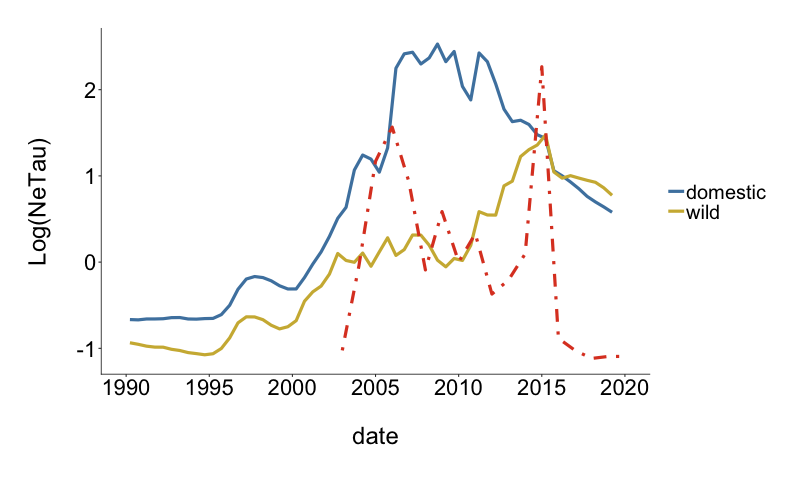

In [52]:
%%R -w 800 -h 500 -u px -i human_cases_df,current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)


output_filename = paste("NeTau-log-with-cases-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)
human_cases_df$year = as.numeric(human_cases_df$year)

# optionally, remove human 
Ne_summary <- Ne_summary[!(Ne_summary$deme=="human"),]

p1 <- ggplot() + 
    geom_line(data=Ne_summary, aes(x=date, y=standardized_log_Ne,group=deme, color=deme, fill=deme), size=1.5)+
#     geom_ribbon(data=Ne_summary, aes(x=date, ymin = standardized_lower_hpd_log, ymax = standardized_upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    geom_line(data=human_cases_df, aes(x=year, y=standardized_cases), color=human_color, linetype=4, size=1.5)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

In [27]:
Ne_summary.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log
0,domestic,0,1.462861,29.030916,3.486958,-0.476321,3068.724480,0.333948,0.0,2019.227,0.578257,0.269866,1.493990
0,domestic,1,1.534148,34.209615,3.470249,-0.283233,2952.899569,0.520916,0.5,2018.727,0.640504,0.377058,1.469704
0,domestic,2,1.599869,39.798693,3.200616,-0.248384,1587.143127,0.564438,1.0,2018.227,0.697890,0.396404,1.077802
0,domestic,3,1.673606,47.163497,3.256195,0.247273,1803.828523,1.767149,1.5,2017.727,0.762276,0.671567,1.158585
0,domestic,4,1.775983,59.701177,3.028982,0.371970,1069.010903,2.354885,2.0,2017.227,0.851669,0.740792,0.828338


In [28]:
Ne_summary_d = Ne_summary[Ne_summary['deme'] == 'domestic']
Ne_summary_d = Ne_summary_d[['deme','mean_Ne_log','date']]
Ne_summary_w = Ne_summary[Ne_summary['deme'] == 'wild']
Ne_summary_w = Ne_summary_w[['deme','mean_Ne_log','date']]
Ne_summary_wd = Ne_summary_d.merge(Ne_summary_w, on="date")

Ne_summary_wd.head()

,deme_x,mean_Ne_log_x,date,deme_y,mean_Ne_log_y
0,domestic,1.462861,2019.227,wild,1.688232
1,domestic,1.534148,2018.727,wild,1.787540
2,domestic,1.599869,2018.227,wild,1.860827
3,domestic,1.673606,2017.727,wild,1.887193
4,domestic,1.775983,2017.227,wild,1.917023


In [29]:
print(min(Ne_summary_wd['mean_Ne_log_x']))
print(min(Ne_summary_wd['mean_Ne_log_y']))

0.030693935382190174
-0.4303124997310347


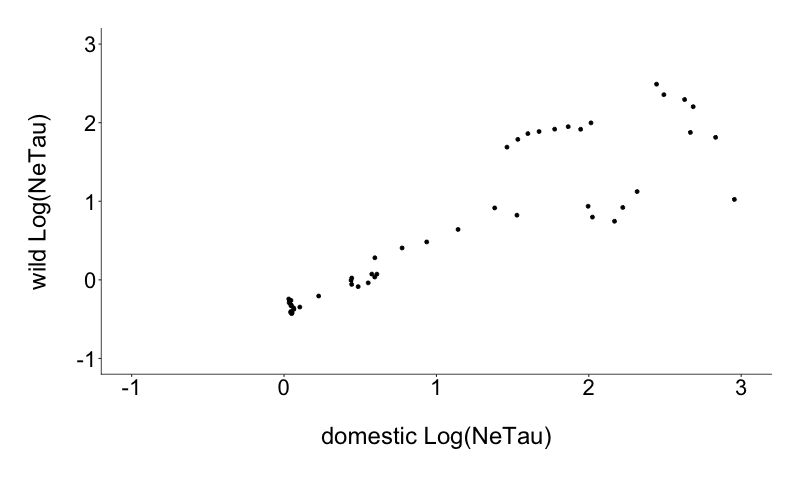

In [56]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary_wd,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("domestic-vs-wild-NeTau-",label,"-",current_date,".pdf", sep="")

p1 <- ggplot(data=Ne_summary_wd, aes(x=mean_Ne_log_x, y=mean_Ne_log_y)) + 
    geom_point(size=1.5)+
    labs(x="\ndomestic Log(NeTau)\n",y="wild Log(NeTau)\n")+
    scale_x_continuous(breaks=seq(-1,3,1), limits=c(-1,3), labels=c(-1,0,1,2,3))+
    scale_y_continuous(breaks=seq(-1,3,1), limits=c(-1,3), labels=c(-1,0,1,2,3))+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

### try plotting correlation between Ne and human cases

In [44]:
def return_year(decimal_date):
    year = str(decimal_date).split(".")[0]
    return(year)

In [45]:
Ne_summary['year'] = Ne_summary['date'].apply(return_year)
Ne_collapsed['year'] = Ne_collapsed['date'].apply(return_year)

In [47]:
# now, merge in dataframes
Ne_and_cases_summary = Ne_summary.merge(human_cases_df, on="year")
Ne_and_cases_summary.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log,year,cases,standardized_cases
0,domestic,0,1.462861,29.030916,3.486958,-0.476321,3068.724480,0.333948,0.0,2019.227,0.578257,0.269866,1.493990,2019,1,-1.093981
1,human,0,-0.002776,0.993629,2.216668,-2.390796,164.690265,0.004066,0.0,2019.227,-0.701505,-0.792949,-0.352331,2019,1,-1.093981
2,wild,0,1.688232,48.778945,3.617106,-0.438736,4141.007736,0.364136,0.0,2019.227,0.775047,0.290731,1.683156,2019,1,-1.093981
3,domestic,1,1.534148,34.209615,3.470249,-0.283233,2952.899569,0.520916,0.5,2018.727,0.640504,0.377058,1.469704,2018,0,-1.117313
4,domestic,2,1.599869,39.798693,3.200616,-0.248384,1587.143127,0.564438,1.0,2018.227,0.697890,0.396404,1.077802,2018,0,-1.117313


In [48]:
# now, merge in dataframes
Ne_and_cases_collapsed = Ne_collapsed.merge(human_cases_df, on="year")
Ne_and_cases_collapsed.head()

,sample,Netau,deme,interval,years_from_present,date,year,cases,standardized_cases
0,0,1.730101,domestic,0,0.0,2019.227,2019,1,-1.093981
1,50000,0.748924,domestic,0,0.0,2019.227,2019,1,-1.093981
2,100000,1.151442,domestic,0,0.0,2019.227,2019,1,-1.093981
3,150000,1.095686,domestic,0,0.0,2019.227,2019,1,-1.093981
4,200000,1.599520,domestic,0,0.0,2019.227,2019,1,-1.093981


## First, plot mean, log NeTau for each interval vs. standardized human cases 

In this plot below, we are plotting the mean Netau estimate per time interval, not the full posterior distribution for each time interval. 

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



Call:
lm(formula = mean_Ne_log ~ standardized_cases, data = Ne_and_cases_summary)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.40586 -0.52925  0.01143  0.55182  1.14876 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          2.5818     0.1173  22.010  < 2e-16 ***
standardized_cases   0.3701     0.1222   3.029  0.00492 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6702 on 31 degrees of freedom
Multiple R-squared:  0.2283,	Adjusted R-squared:  0.2034 
F-statistic: 9.172 on 1 and 31 DF,  p-value: 0.004919



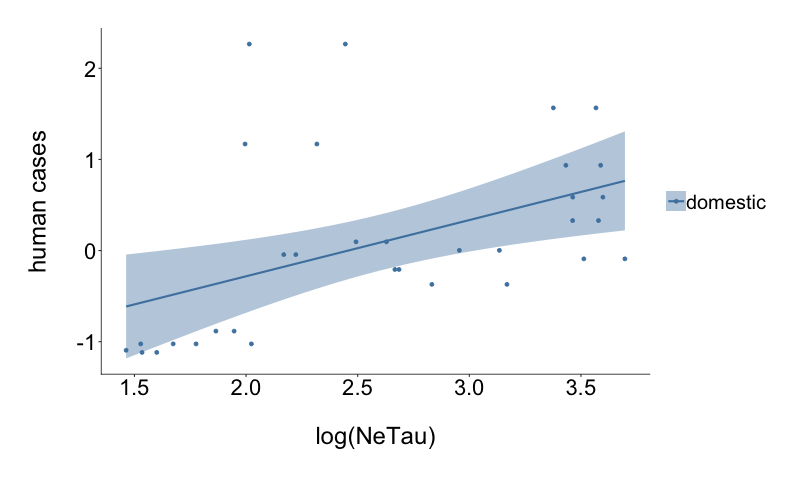

In [49]:
%%R -w 800 -h 500 -u px -i Ne_and_cases_summary,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("domestic-NeTau-log-vs-cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases_summary$interval = as.numeric(Ne_and_cases_summary$interval)
Ne_and_cases_summary$year = as.numeric(Ne_and_cases_summary$year)

# optionally, just do domestic 
Ne_and_cases_summary <- Ne_and_cases_summary[(Ne_and_cases_summary$deme=="domestic"),]

reg1 <- lm(mean_Ne_log~standardized_cases,data=Ne_and_cases_summary) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases_summary, aes(x=mean_Ne_log, y=standardized_cases,group=deme, color=deme, fill=deme)) + 
    geom_point(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1


Call:
lm(formula = mean_Ne_log ~ standardized_cases, data = Ne_and_cases)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.70149 -0.44782 -0.03369  0.41729  1.19609 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.43550    0.09726  14.759 1.44e-15 ***
standardized_cases -0.06272    0.10132  -0.619     0.54    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5557 on 31 degrees of freedom
Multiple R-squared:  0.01221,	Adjusted R-squared:  -0.01965 
F-statistic: 0.3832 on 1 and 31 DF,  p-value: 0.5404



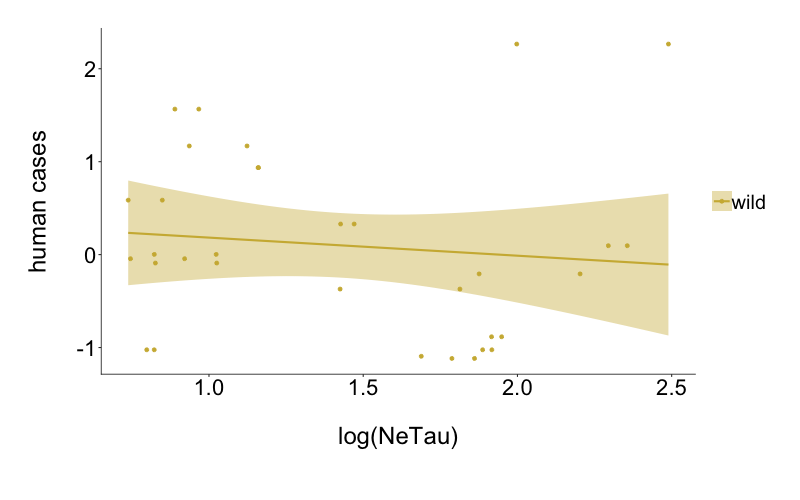

In [63]:
%%R -w 800 -h 500 -u px -i Ne_and_cases,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("wild-NeTau-log-vs-cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases$interval = as.numeric(Ne_and_cases$interval)
Ne_and_cases$year = as.numeric(Ne_and_cases$year)

# optionally, just do domestic 
Ne_and_cases <- Ne_and_cases[(Ne_and_cases$deme=="wild"),]

reg1 <- lm(mean_Ne_log~standardized_cases,data=Ne_and_cases) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases, aes(x=mean_Ne_log, y=standardized_cases,group=deme, color=deme, fill=deme)) + 
    geom_point(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1


Call:
lm(formula = mean_Ne_log ~ standardized_cases, data = Ne_and_cases)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8085 -0.2653 -0.1052  0.4251  0.7094 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.52395    0.07826   6.695 1.73e-07 ***
standardized_cases  0.23480    0.08152   2.880  0.00715 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4471 on 31 degrees of freedom
Multiple R-squared:  0.2111,	Adjusted R-squared:  0.1857 
F-statistic: 8.295 on 1 and 31 DF,  p-value: 0.007148



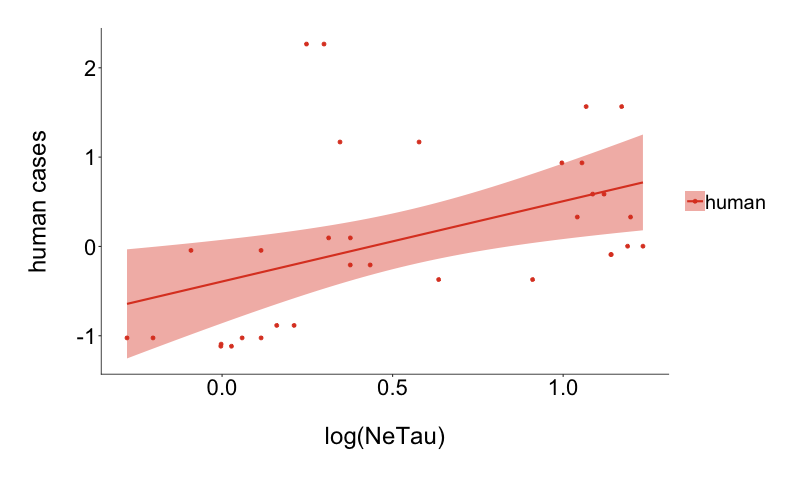

In [64]:
%%R -w 800 -h 500 -u px -i Ne_and_cases,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("human-NeTau-log-vs-cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases$interval = as.numeric(Ne_and_cases$interval)
Ne_and_cases$year = as.numeric(Ne_and_cases$year)

# optionally, just do domestic 
Ne_and_cases <- Ne_and_cases[(Ne_and_cases$deme=="human"),]

reg1 <- lm(mean_Ne_log~standardized_cases,data=Ne_and_cases) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases, aes(x=mean_Ne_log, y=standardized_cases,group=deme, color=deme, fill=deme)) + 
    geom_point(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

## Now plot full posterior 

In [50]:
Ne_and_cases_collapsed.head()

,sample,Netau,deme,interval,years_from_present,date,year,cases,standardized_cases
0,0,1.730101,domestic,0,0.0,2019.227,2019,1,-1.093981
1,50000,0.748924,domestic,0,0.0,2019.227,2019,1,-1.093981
2,100000,1.151442,domestic,0,0.0,2019.227,2019,1,-1.093981
3,150000,1.095686,domestic,0,0.0,2019.227,2019,1,-1.093981
4,200000,1.599520,domestic,0,0.0,2019.227,2019,1,-1.093981



Call:
lm(formula = Netau ~ standardized_cases, data = Ne_and_cases_collapsed)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9985 -0.5437  0.1297  0.6020  3.2961 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.581809   0.002339  1103.9   <2e-16 ***
standardized_cases 0.370079   0.002436   151.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8063 on 120151 degrees of freedom
Multiple R-squared:  0.1611,	Adjusted R-squared:  0.1611 
F-statistic: 2.307e+04 on 1 and 120151 DF,  p-value: < 2.2e-16



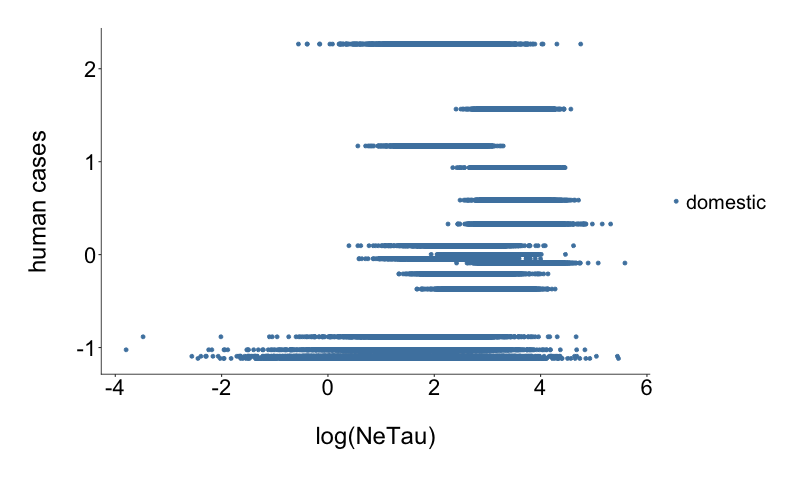

In [54]:
%%R -w 800 -h 500 -u px -i Ne_and_cases_collapsed,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("domestic-NeTau-log-vs-cases-posterior-",label,"-",current_date,".pdf", sep="")

Ne_and_cases_collapsed$interval = as.numeric(Ne_and_cases_collapsed$interval)
Ne_and_cases_collapsed$year = as.numeric(Ne_and_cases_collapsed$year)

# optionally, just do domestic 
Ne_and_cases_collapsed <- Ne_and_cases_collapsed[(Ne_and_cases_collapsed$deme=="domestic"),]

reg1 <- lm(Netau~standardized_cases,data=Ne_and_cases_collapsed) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases_collapsed, aes(x=Netau, y=standardized_cases, color=deme, fill=deme)) + 
    geom_point(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    #geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

In [65]:
# calculate a correlation coefficient
import scipy.stats

# human
human_Ne_df = Ne_and_cases[Ne_and_cases['deme'] == "human"]
human_Ne = human_Ne_df['mean_Ne_log']
human_cases_h = human_Ne_df['standardized_cases']

# domestic first 
domestic_Ne_df = Ne_and_cases[Ne_and_cases['deme'] == "domestic"]
domestic_Ne = domestic_Ne_df['mean_Ne_log']
human_cases_d = domestic_Ne_df['standardized_cases']

# wild
wild_Ne_df = Ne_and_cases[Ne_and_cases['deme'] == "wild"]
wild_Ne = wild_Ne_df['mean_Ne_log']
human_cases_w = wild_Ne_df['standardized_cases']

# this prints the correlation and the p-value
scipy.stats.pearsonr(domestic_Ne, human_cases_d)

(0.4778259503035928, 0.004919175597923808)

In [66]:
# correlation, p-value
scipy.stats.pearsonr(wild_Ne, human_cases_w)

(-0.11050669207896403, 0.5403955167968054)

In [67]:
# correlation, p-value
scipy.stats.pearsonr(human_Ne, human_cases_w)

(0.45946087285366677, 0.007147566846702262)

In [68]:
# wild vs. domestic 
scipy.stats.pearsonr(domestic_Ne, wild_Ne)

(-0.3880965772064614, 0.02562978968245359)

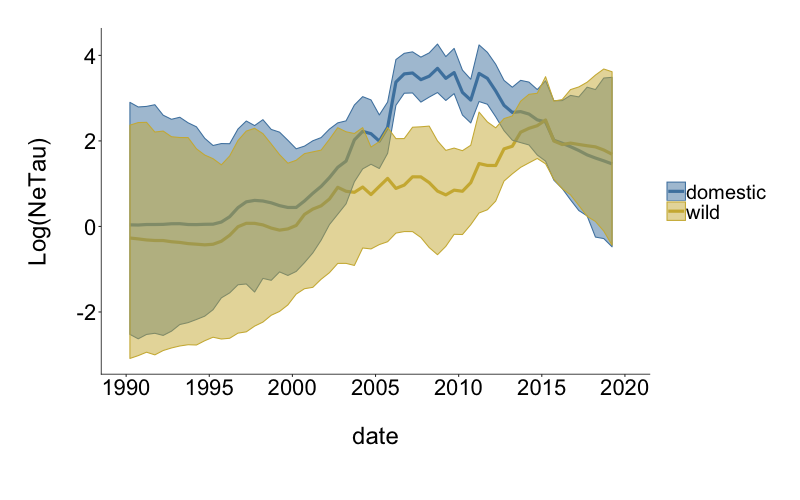

In [69]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-log-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove human 
Ne_summary <- Ne_summary[!(Ne_summary$deme=="human"),]

p <- ggplot(data=Ne_summary, aes(x=date, y=mean_Ne_log,group=deme, color=deme, fill=deme)) + 
    geom_line(size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_log, ymax = upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

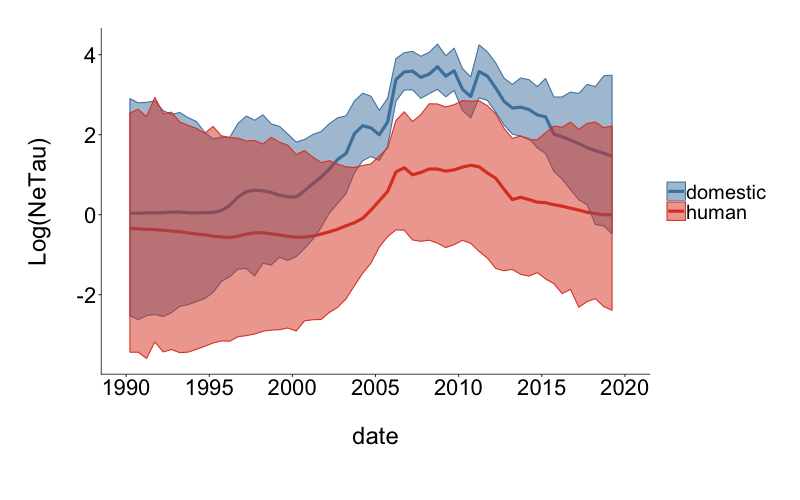

In [70]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-log-2-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove wild
Ne_summary <- Ne_summary[!(Ne_summary$deme=="wild"),]

p <- ggplot(data=Ne_summary, aes(x=date, y=mean_Ne_log,group=deme, color=deme, fill=deme)) + 
    geom_line(size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_log, ymax = upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

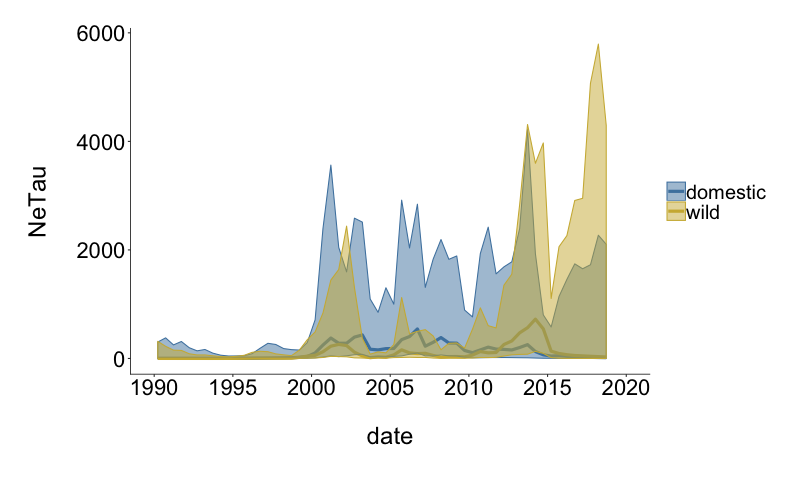

In [176]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-linear-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove human 
Ne_summary <- Ne_summary[!(Ne_summary$deme=="human"),]

p <- ggplot(data=Ne_summary, aes(x=date, y=mean_Ne_linear,group=deme, color=deme, fill=deme)) + 
    geom_line(size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_linear, ymax = upper_hpd_linear,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="NeTau\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

In [47]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [140]:
all_trees = "beast-runs/2021-02-16-mascot-3deme/test.trees"
burnin_percent = 0.0

taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

0.0


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


In [157]:
def return_persistence_times(tree, return_dict):
            
    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k
        
        if 'max' in k.traits:
            host = k.traits['max']
        else:
            host = 'ancestor'
        
        if k.branchType == "node":
            children = k.children
            
            ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            traverse_condition=lambda w:w.traits['max'].lower().replace()==kloc
            subtree=tree.subtree(k,traverse_condition=traverse_condition) 


In [158]:
hosts_dict = {'human':[],'domestic':[],'wild':[]}
return_persistence_times(tree, hosts_dict)

[<baltic.node object at 0x7fb1c3d19f28>, <baltic.node object at 0x7fb1c6c065f8>]
[<baltic.node object at 0x7fb1c3d19ef0>, <baltic.node object at 0x7fb1c6c062b0>]
[<baltic.node object at 0x7fb1dc6f1400>, <baltic.node object at 0x7fb1da3c4710>]
[<baltic.node object at 0x7fb1c3483470>, <baltic.node object at 0x7fb1dfd05630>]
[<baltic.node object at 0x7fb1c69f2f28>, <baltic.node object at 0x7fb1dfd05198>]
[<baltic.node object at 0x7fb1dacade80>, <baltic.node object at 0x7fb1c72317f0>]
[<baltic.node object at 0x7fb1c3670400>, <baltic.node object at 0x7fb1c7231ef0>]
[<baltic.leaf object at 0x7fb1c20c0f28>, <baltic.node object at 0x7fb1c72319b0>]
[<baltic.node object at 0x7fb1c2bdfb00>, <baltic.node object at 0x7fb1c3309eb8>]
[<baltic.node object at 0x7fb1c2e5ada0>, <baltic.node object at 0x7fb1c0484320>]
[<baltic.node object at 0x7fb1c698c160>, <baltic.node object at 0x7fb1c04841d0>]
[<baltic.node object at 0x7fb1c698cb70>, <baltic.node object at 0x7fb1c802add8>]
[<baltic.node object at 0x7f

In [ ]:
from io import StringIO
import time
start_time = time.time()

with open(all_trees, "r") as infile:
    
    tree_counter = 0
    
    for line in infile:
        if 'tree STATE_' in line:
            tree_counter += 1
            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree)
                print(tree)

                hosts_list = ['human','wild','domestic']
                subtype_trees = retrieve_subtrees(tree)
                cluster_times_dict = output_cluster_times(subtype_trees)
            
print("My program took", time.time() - start_time, "to run")